In [1]:
import pyarrow
import fastparquet
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import re


## Exploratory Analysis - Data Preview 

In [2]:
#Data Download and Preview 
df = pd.read_parquet('/Users/camryncurtis/Documents/GitHub/Capstone-Project/data/raw/prepros_summer_lax_snappy.parquet')
print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  006987aea766442f625ccd84bde23ff3  2022-04-17  2022-06-01             LAX   
1  2181b0ab7161f081228a0c600d756eaf  2022-04-17  2022-06-01             LAX   
2  1ad5b31e3269695b008e5001f06d627a  2022-04-17  2022-06-01             LAX   
3  8e3f3570d010c80500d98f66bfc49777  2022-04-17  2022-06-01             LAX   
4  7ff208a7f5d75b1a97d54b983eb4fabf  2022-04-17  2022-06-01             LAX   

  destinationAirport fareBasisCode travelDuration  isBasicEconomy  \
0                ATL         GA7NR       PT14H25M           False   
1                ATL         GA7NR       PT10H42M           False   
2                ATL         UA7NR        PT9H49M           False   
3                ATL        U0XSNR       PT12H42M           False   
4                ATL       M03PXP5        PT6H17M           False   

   isRefundable  isNonStop  ...  seatsRemaining  totalTravelDistance  \
0         False      False  ...       

In [3]:
#Datatype and Summary Statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329731 entries, 0 to 4329730
Data columns (total 22 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   fareBasisCode                      object 
 6   travelDuration                     object 
 7   isBasicEconomy                     bool   
 8   isRefundable                       bool   
 9   isNonStop                          bool   
 10  baseFare                           float64
 11  totalFare                          float64
 12  seatsRemaining                     int64  
 13  totalTravelDistance                float64
 14  segmentsDepartureTimeEpochSeconds  object 
 15  segmentsArrivalTimeEpochSeconds    object 
 16  segmentsArrivalAir

In [4]:
#Handle Data Types

# Convert boolean columns to 0 and 1
boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop'] 
df[boolean_columns] = df[boolean_columns].astype(int)

#Change dates to datetime
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])

#Convert travelDuration from ISO 8601 to minutes 
def convert_duration(duration):
    if not isinstance(duration, str): 
        return None
    
    match = re.match(r'P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?', duration)
    if match:
        days = int(match.group(1)) if match.group(1) else 0
        hours = int(match.group(2)) if match.group(2) else 0
        minutes = int(match.group(3)) if match.group(3) else 0
        return (days * 24 * 60) + (hours * 60) + minutes  # Convert everything to minutes

    return None 

df[df['travelDuration'].apply(lambda x: convert_duration(x) is None)]


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,isBasicEconomy,isRefundable,isNonStop,...,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsArrivalTimeEpochSeconds,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


legId                                     0
searchDate                                0
flightDate                                0
startingAirport                           0
destinationAirport                        0
fareBasisCode                             0
travelDuration                            0
isBasicEconomy                            0
isRefundable                              0
isNonStop                                 0
baseFare                                  0
totalFare                                 0
seatsRemaining                            0
totalTravelDistance                  456372
segmentsDepartureTimeEpochSeconds         0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineName                       0
segmentsDurationInSeconds                 0
segmentsDistance                          0
segmentsCabinCode                         0
dtype: int64


In [6]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [7]:
# Count occurrences of each legId
legid_counts = df['legId'].value_counts()
print(legid_counts.head(10))

#Statistics about legId occurrences
print("Unique legIds:", legid_counts.count())
print("Max occurrences of a legId:", legid_counts.max())
print("Min occurrences of a legId:", legid_counts.min())
print("Average occurrences per legId:", legid_counts.mean())

# Check how many legIds occur only once
single_occurrences = (legid_counts == 1).sum()
sixty_occurrences = (legid_counts == 60).sum()
print("Number of legIds that appear only once:", single_occurrences)
print("Number of legIds that appear 60 times:", sixty_occurrences)

legId
c22a75ae4a2f1141ca61885ab59fc5ea    60
ab60059b7da6940221d46e6ead8e33a7    60
2a25de2a7e90bf86161ab93438eda3c3    60
ef30ee06a2fd38a6a58f1dd57002e99b    60
d55f91e18db1bc831f4940bb21c443f6    60
ebcba5004142de624bc837c6b0ace1d5    60
cd4317efc4b2bde629cd15fe2238929e    60
2ff66104e981a562a6e9cd5ff5fdc50a    60
e87e5494b8041c2c5162325f7f49a044    60
b2d0acaaa4d0d64ef6db64bcb661eeda    60
Name: count, dtype: int64
Unique legIds: 296163
Max occurrences of a legId: 60
Min occurrences of a legId: 1
Average occurrences per legId: 14.619419036138883
Number of legIds that appear only once: 60055
Number of legIds that appear 60 times: 1785


In [8]:
# Drop rows where 'totalTravelDistance' is null
df = df[df['totalTravelDistance'].notna()]

#Drop column startingAirport. LAX is the only starting airport 
#Drop legId, offers no useful prediction tools and isn't needed for any other use
#Drop baseFare, only need one between baseFare and totalFare (totalFare more comprehensive)
#We are interested in the departing and arriving airport code only, so the intermediate airport code can be dropped 
df = df.drop(['startingAirport', 'legId', 'baseFare'], axis=1).reset_index(drop=True)

## Feature Engineering 

In [9]:
#Time Related Features
df['days_to_departure'] = (df['flightDate'] - df['searchDate']).dt.days

df['flight_month'] = df['flightDate'].dt.month
df['flight_day'] = df['flightDate'].dt.dayofweek

df['search_month'] = df['searchDate'].dt.month
df['search_day'] = df['searchDate'].dt.dayofweek

us_holidays = holidays.US()
df['is_holiday'] = df['flightDate'].apply(lambda date: 1 if date in us_holidays else 0)

#All elements of flightDate have been extracted, drop flightDate
df = df.drop(['flightDate'], axis=1).reset_index(drop=True)

In [10]:
# Split segments by cabin code?

### Segment Feature Engineering 


In [ ]:
df['numberLegs'] = df['segmentsDepartureTimeEpochSeconds'].str.count(r'\|\|') + 1
max_segments = df['numberLegs'].max()

print(f"Maximum number of segments in any row: {max_segments}")



KeyError: 'segmentsDepartureTimeEpochSeconds'

In [19]:
# Split departure and arrivals into separate columns
df[['dep_1', 'dep_2', 'dep_3', 'dep_4']] = df['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|', expand=True)
df[['arr_1', 'arr_2', 'arr_3', 'arr_4']] = df['segmentsArrivalTimeEpochSeconds'].str.split(r'\|\|', expand=True)

# Convert epoch times to datetime
for col in ['dep_1', 'dep_2', 'dep_3', 'dep_4', 'arr_1', 'arr_2', 'arr_3', 'arr_4']:
    df[col] = pd.to_datetime(df[col].astype(float), unit='s', errors='coerce')
    

In [20]:
#Find hour of departure and arrival. Inspired by literature
df["departureHour"] = df["dep_1"].dt.hour
df["departureMinute"] = df["dep_1"].dt.minute

# Get the last valid arrival time by backfilling from right to left
df["final_arrival"] = df[["arr_4", "arr_3", "arr_2", "arr_1"]].bfill(axis=1).iloc[:, 0]

# Extract hour and minute from the final arrival time
df["arrivalHour"] = df["final_arrival"].dt.hour
df["arrivalMinute"] = df["final_arrival"].dt.minute

# Create a column to check if final arrival is on the next day and convert to 0/1
df["arrivalNextDay"] = (df["final_arrival"].dt.date > df["dep_1"].dt.date).astype(int)


# Drop the intermediate column if not needed
df.drop(columns=["final_arrival"], inplace=True)



In [21]:
# Calculate layover times for each segment
def calculate_layover(dep_col, arr_col, next_dep_col):
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (next_dep_col - arr_col).total_seconds() / 3600 if pd.notna(next_dep_col) else 0
    return 0

# Calculate layover times for each segment
df['layover_1'] = df.apply(lambda row: calculate_layover(row['dep_1'], row['arr_1'], row['dep_2']), axis=1)
df['layover_2'] = df.apply(lambda row: calculate_layover(row['dep_2'], row['arr_2'], row['dep_3']), axis=1)
df['layover_3'] = df.apply(lambda row: calculate_layover(row['dep_3'], row['arr_3'], row['dep_4']), axis=1)

# Sum layover times, handling NaNs
df['totalLayoverTime'] = df[['layover_1', 'layover_2', 'layover_3']].sum(axis=1, skipna=True)




In [22]:
# Calculate the total flight duration, excluding layovers
def calculate_flight_duration(row):
    total_duration = 0
    num_segments = row['numberLegs']
    
    # Ensure there are valid departure and arrival times to compute the duration
    if num_segments >= 1 and pd.notna(row['dep_1']) and pd.notna(row[f'arr_{num_segments}']):
        # Total time between first departure and last arrival
        total_duration = (row[f'arr_{num_segments}'] - row['dep_1']).total_seconds() / 3600
    
    # Subtract layover times to get only time spent flying
    total_duration -= row['totalLayoverTime']
    
    return total_duration

# Apply the function to calculate total flight duration
df['totalAirtime'] = df.apply(calculate_flight_duration, axis=1)

In [23]:
# Calculate segment durations for each leg
def calculate_segment_duration(dep_col, arr_col):
    """Calculate the duration of a segment between departure and arrival times."""
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (arr_col - dep_col).total_seconds() / 3600  # Duration in hours
    return 0

# Apply the function to calculate segment durations for each leg
df['segment_1_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_1'], row['arr_1']), axis=1)
df['segment_2_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_2'], row['arr_2']), axis=1)
df['segment_3_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_3'], row['arr_3']), axis=1)
df['segment_4_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_4'], row['arr_4']), axis=1)

# Update max_segment_duration by finding the maximum duration of the available segments
df['maxSegmentDuration'] = df[['segment_1_duration', 'segment_2_duration', 'segment_3_duration', 'segment_4_duration']].max(axis=1, skipna=True)

# Calculate minimum segment duration (excluding zero durations)
def calculate_min_segment_duration(row):
    """Calculate minimum segment duration excluding zero values."""
    segment_durations = [
        row['segment_1_duration'],
        row['segment_2_duration'],
        row['segment_3_duration'],
        row['segment_4_duration']
    ]
    
    # Filter out zero durations and find the minimum
    non_zero_durations = [duration for duration in segment_durations if duration > 0]
    
    if non_zero_durations:  # Check if there are non-zero durations
        return min(non_zero_durations)
    else:
        return 0  # Return 0 if no valid segment durations are found

# Apply the function to calculate the minimum segment duration
df['minSegmentDuration'] = df.apply(calculate_min_segment_duration, axis=1)

# Calculate average segment duration (excluding zero durations)
def calculate_avg_segment_duration(row):
    """Calculate average segment duration excluding zero values."""
    segment_durations = [
        row['segment_1_duration'],
        row['segment_2_duration'],
        row['segment_3_duration'],
        row['segment_4_duration']
    ]
    
    # Filter out zero durations
    non_zero_durations = [duration for duration in segment_durations if duration > 0]
    
    if non_zero_durations:  # Check if there are non-zero durations
        return sum(non_zero_durations) / len(non_zero_durations)
    else:
        return 0  # Return 0 if no valid segment durations are found

# Apply the function to calculate the average segment duration
df['averageSegmentDuration'] = df.apply(calculate_avg_segment_duration, axis=1)




In [44]:
# Extract the first layover airport code (if it exists)
# Assuming the 'segmentsArrivalAirportCode' column contains the layover airport codes, separated by '||'
df['firstLayoverAirport'] = df['segmentsArrivalAirportCode'].str.split('||').str[0]


In [45]:
# Extracting the main Airline Carrier for the flight 
# Split the airline names, then find the most common one
df['mainAirline'] = df['segmentsAirlineName'].str.split('||').apply(lambda x: max(set(x), key=x.count))


In [53]:
# Use raw string to avoid escape sequence warning
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Remove any unnecessary characters (like leading/trailing spaces or empty strings)
df['cabin_classes'] = df['cabin_classes'].apply(lambda x: [i.strip() for i in x if i.strip() != ''])

# Verify the first few rows to ensure proper splitting
print(df['cabin_classes'].head())

# Check if all cabin classes are the same for each flight
df['same_cabin_type'] = df['cabin_classes'].apply(lambda x: len(set(x)) == 1)

# Count flights with same vs. different cabin types
same_cabin_count = df['same_cabin_type'].sum()
different_cabin_count = len(df) - same_cabin_count

print(f"Number of flights with the same cabin type: {same_cabin_count}")
print(f"Number of flights with different cabin types: {different_cabin_count}")

# Split based on '||' and find unique cabin classes
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Flatten the list and get the unique cabin classes
unique_cabin_classes = df['cabin_classes'].explode().unique()

# Display the unique cabin classes
print("Unique cabin classes:", unique_cabin_classes)



0    [coach, coach]
1    [coach, coach]
2    [coach, coach]
3    [coach, coach]
4    [coach, coach]
Name: cabin_classes, dtype: object
Number of flights with the same cabin type: 3865627
Number of flights with different cabin types: 7732
Unique cabin classes: ['coach' 'premium coach' 'first' 'business']


In [58]:
# Split the cabin classes and generate a combination
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')
df['cabin_classes_combination'] = df['cabin_classes'].apply(lambda x: '|'.join(sorted(set(x))))

#Define the ordered combinations
ordered_combinations = [
    'coach',
    'coach|premium coach',
    'premium coach',
    'coach|business',
    'premium coach|business',
    'business',
    'coach|first',
    'premium coach|first',
    'first|business',
    'first'
]

# Create an ordinal mapping
combination_mapping = {comb: idx for idx, comb in enumerate(ordered_combinations)}

# Map the combinations to their ordinal values
df['cabin_classes_ordinal'] = df['cabin_classes_combination'].map(combination_mapping)



,segmentsCabinCode,cabin_classes_combination,cabin_classes_ordinal
0,coach||coach,coach,0.0
1,coach||coach,coach,0.0
2,coach||coach,coach,0.0
3,coach||coach,coach,0.0
4,coach||coach,coach,0.0


In [24]:
#Drop Departure and Arrival columns now that all necessary information has been extracted
df = df.drop(columns=['segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds',
                      'dep_1', 'dep_2', 'dep_3', 'dep_4', 
                      'arr_1', 'arr_2', 'arr_3', 'arr_4', 
                      'layover_1', 'layover_2', 'layover_3', 
                      'segment_1_duration','segment_2_duration', 'segment_3_duration' ,'segment_4_duration', 
                      'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
                      'segmentsAirlineName', 'segmentsCabinCode'])

### Lag Features
Lag features represent the values of a variable at previous time points


There are a high occurrence of legIds that only appear once, meaning the use of legId for grouping of lag features is not ideal, it can lead to excessive granularity and not be as useful of a feature. Instead, we can group by starting and destination airports. 

In [25]:
# Sort by route and search date
df = df.sort_values(by=['destinationAirport', 'searchDate'])

# Create lag features for 1-day, 7-day, and 30-day periods
df['fare_lag_1'] = df.groupby(['destinationAirport'])['totalFare'].shift(1)
df['fare_lag_7'] = df.groupby(['destinationAirport'])['totalFare'].shift(7)
df['fare_lag_30'] = df.groupby(['destinationAirport'])['totalFare'].shift(30)

# Create rolling average features
df['fare_rolling_avg_7'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['fare_rolling_avg_30'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Fill missing values in lag features using rolling averages
df['fare_lag_1'] = df['fare_lag_1'].fillna(df['fare_rolling_avg_30'])  # Prefer 30-day average
df['fare_lag_1'] = df['fare_lag_1'].fillna(df['fare_rolling_avg_7'])   # If still NaN, use 7-day avg
df['fare_lag_1'] = df['fare_lag_1'].fillna(method='ffill')             # Finally, use forward fill

# Inspect the results
print(df[['destinationAirport', 'searchDate', 'totalFare', 'fare_lag_1', 'fare_rolling_avg_7', 'fare_rolling_avg_30']].head(20))


/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_7630/2235148256.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fare_lag_1'] = df['fare_lag_1'].fillna(method='ffill')             # Finally, use forward fill


   destinationAirport searchDate  totalFare  fare_lag_1  fare_rolling_avg_7  \
0                 ATL 2022-04-17     193.99      193.99          193.990000   
1                 ATL 2022-04-17     248.61      193.99          221.300000   
2                 ATL 2022-04-17     277.60      248.61          240.066667   
3                 ATL 2022-04-17     277.60      277.60          249.450000   
4                 ATL 2022-04-17     277.60      277.60          255.080000   
5                 ATL 2022-04-17     277.60      277.60          258.833333   
6                 ATL 2022-04-17     323.60      277.60          268.085714   
7                 ATL 2022-04-17     323.60      323.60          286.601429   
8                 ATL 2022-04-17     323.60      323.60          297.314286   
9                 ATL 2022-04-17     323.60      323.60          303.885714   
10                ATL 2022-04-17     323.60      323.60          310.457143   
11                ATL 2022-04-17     327.60      323

In [26]:
# Check correlation of lag and rolling averages to the totalFare to understand what is useful

correlation_features = df[['totalFare', 'fare_lag_1', 'fare_lag_7', 'fare_lag_30', 
                           'fare_rolling_avg_7', 'fare_rolling_avg_30']]

correlation_matrix = correlation_features.corr()
print(correlation_matrix)


                     totalFare  fare_lag_1  fare_lag_7  fare_lag_30  \
totalFare             1.000000    0.814436    0.465841     0.268638   
fare_lag_1            0.814436    1.000000    0.495629     0.267664   
fare_lag_7            0.465841    0.495629    1.000000     0.276153   
fare_lag_30           0.268638    0.267664    0.276153     1.000000   
fare_rolling_avg_7    0.798418    0.851947    0.708722     0.316201   
fare_rolling_avg_30   0.591515    0.617960    0.704194     0.556135   

                     fare_rolling_avg_7  fare_rolling_avg_30  
totalFare                      0.798418             0.591515  
fare_lag_1                     0.851947             0.617960  
fare_lag_7                     0.708722             0.704194  
fare_lag_30                    0.316201             0.556135  
fare_rolling_avg_7             1.000000             0.765108  
fare_rolling_avg_30            0.765108             1.000000  


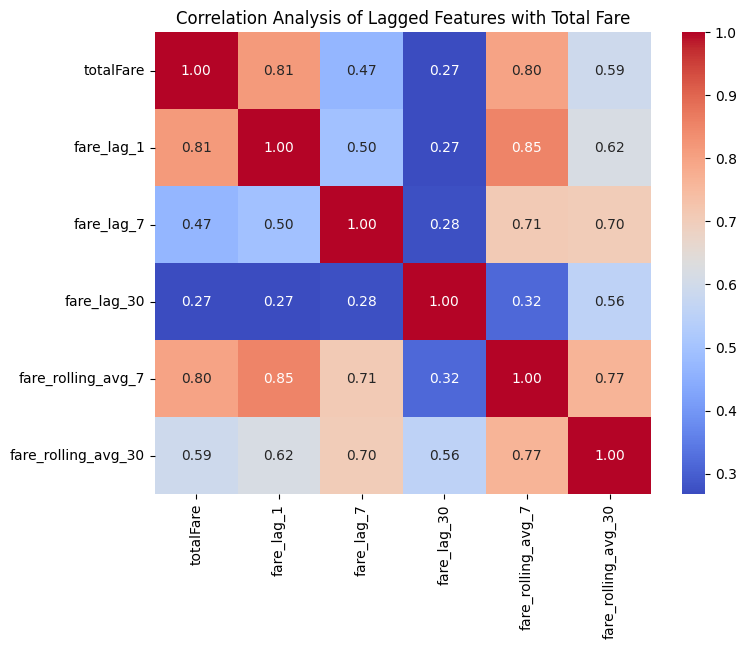

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Analysis of Lagged Features with Total Fare")
plt.show()


The most correlated features are fare_lag_1, fare_rolling_avg_7, and fare_rolling_avg_30. However, fare_lag_1 and fare_rolling_avg_7 have high correlation with each other, which may introduce redundancy into the model. One may need to be dropped if multicollinearity affects model 

In [28]:
#Drop the lag features that do not have a high correlation with totalFare
df = df.drop(['fare_rolling_avg_7', 'fare_lag_7', 'fare_lag_30'], axis=1)

#All elements of searchDate have been extracted, drop searchDate
df = df.drop(columns=['searchDate'], axis=1)

## Data Visualizations


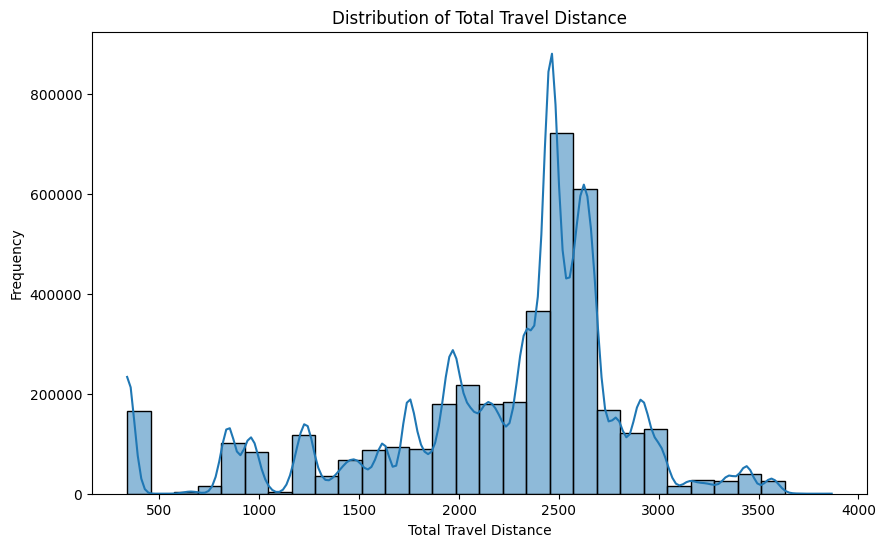

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df['totalTravelDistance'], bins=30, kde=True)
plt.title('Distribution of Total Travel Distance')
plt.xlabel('Total Travel Distance')
plt.ylabel('Frequency')
plt.show()


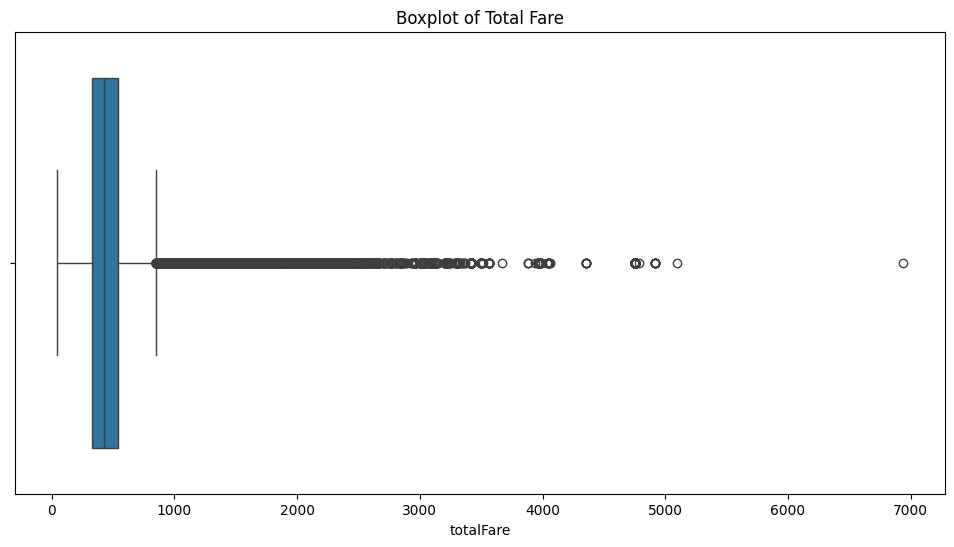

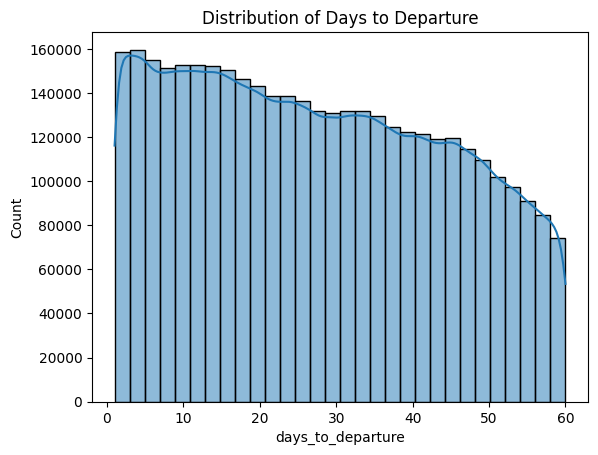

In [30]:
# Visualize totalFare and baseFare distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['totalFare'])
plt.title("Boxplot of Total Fare")
plt.show()

# Distribution of days to departure
sns.histplot(df['days_to_departure'], bins=30, kde=True)
plt.title("Distribution of Days to Departure")
plt.show()


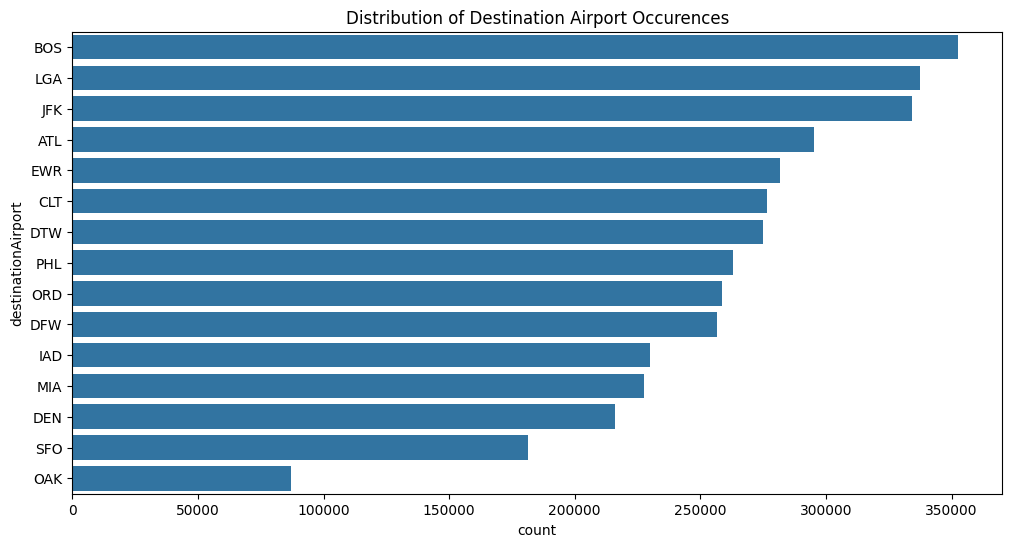

In [31]:
# Frequency analysis for destination airports (Starting airport is always LAX)
plt.figure(figsize=(12, 6))
sns.countplot(y=df['destinationAirport'], order=df['destinationAirport'].value_counts().index[:15])
plt.title("Distribution of Destination Airport Occurences")
plt.show()

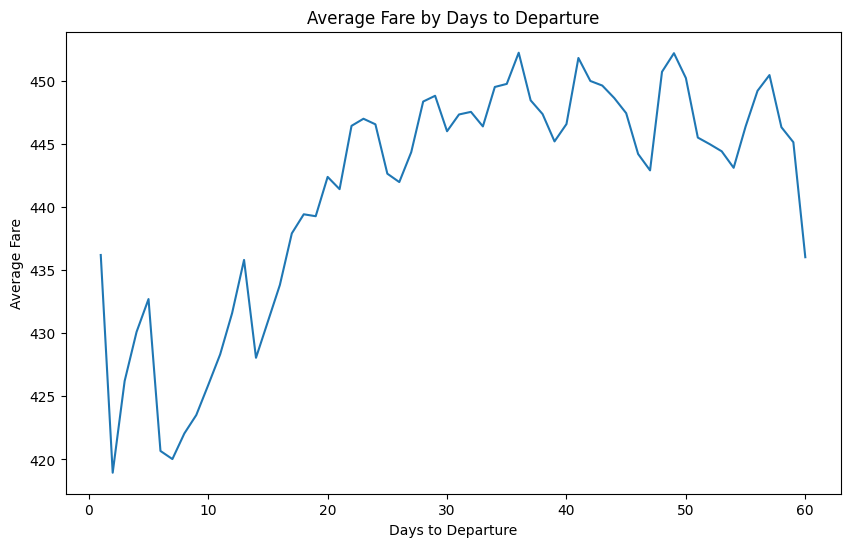

In [32]:
# Group by days to departure to analyze average fare trends
avg_fare_trend = df.groupby('days_to_departure')['totalFare'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_fare_trend, x='days_to_departure', y='totalFare')
plt.title("Average Fare by Days to Departure")
plt.xlabel("Days to Departure")
plt.ylabel("Average Fare")
plt.show()


/Users/camryncurtis/Documents/GitHub/Capstone-Project/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


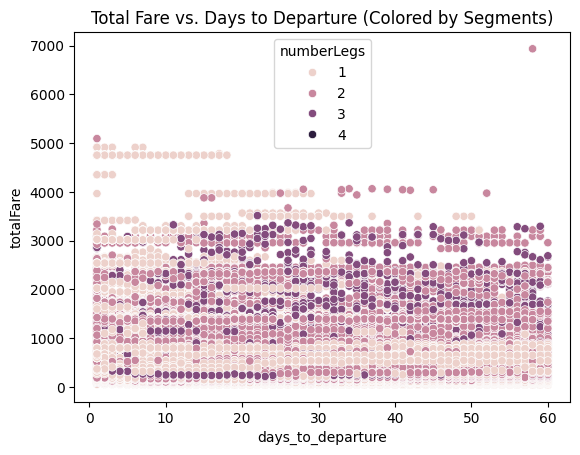

In [34]:
# Scatterplot of totalFare vs. days_to_departure
sns.scatterplot(x=df['days_to_departure'], y=df['totalFare'], hue=df['numberLegs'])
plt.title("Total Fare vs. Days to Departure (Colored by Segments)")
plt.show()


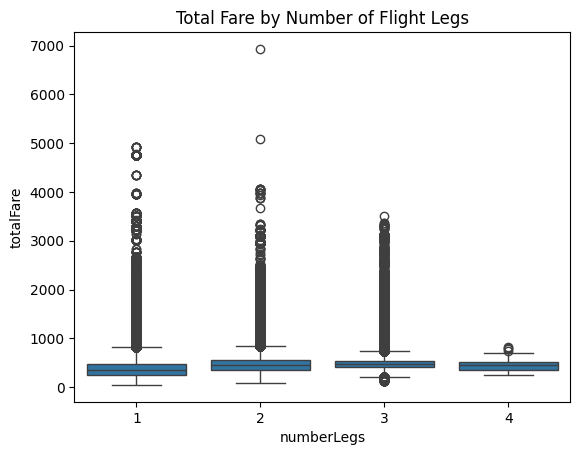

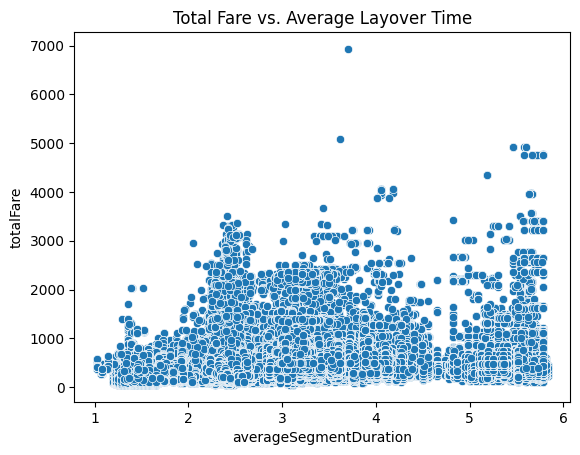

In [37]:
# Relationship between number of segments and totalFare
sns.boxplot(x='numberLegs', y='totalFare', data=df)
plt.title("Total Fare by Number of Flight Legs")
plt.show()

# Average segment duration vs. total fare
sns.scatterplot(x='averageSegmentDuration', y='totalFare', data=df)
plt.title("Total Fare vs. Average Layover Time")
plt.show()


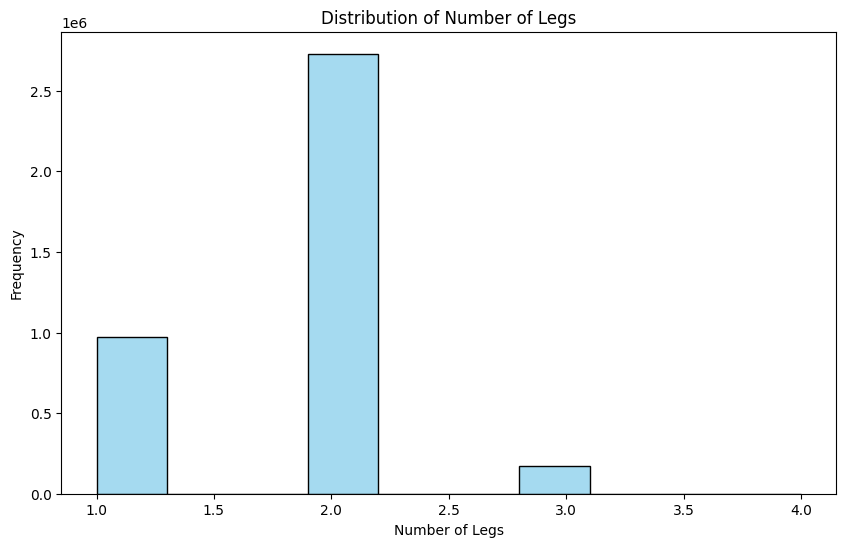

In [40]:
plt.figure(figsize=(10,6))
sns.histplot(df['numberLegs'], bins=10, kde=False, color='skyblue')
plt.title("Distribution of Number of Legs")
plt.xlabel("Number of Legs")
plt.ylabel("Frequency")
plt.show()


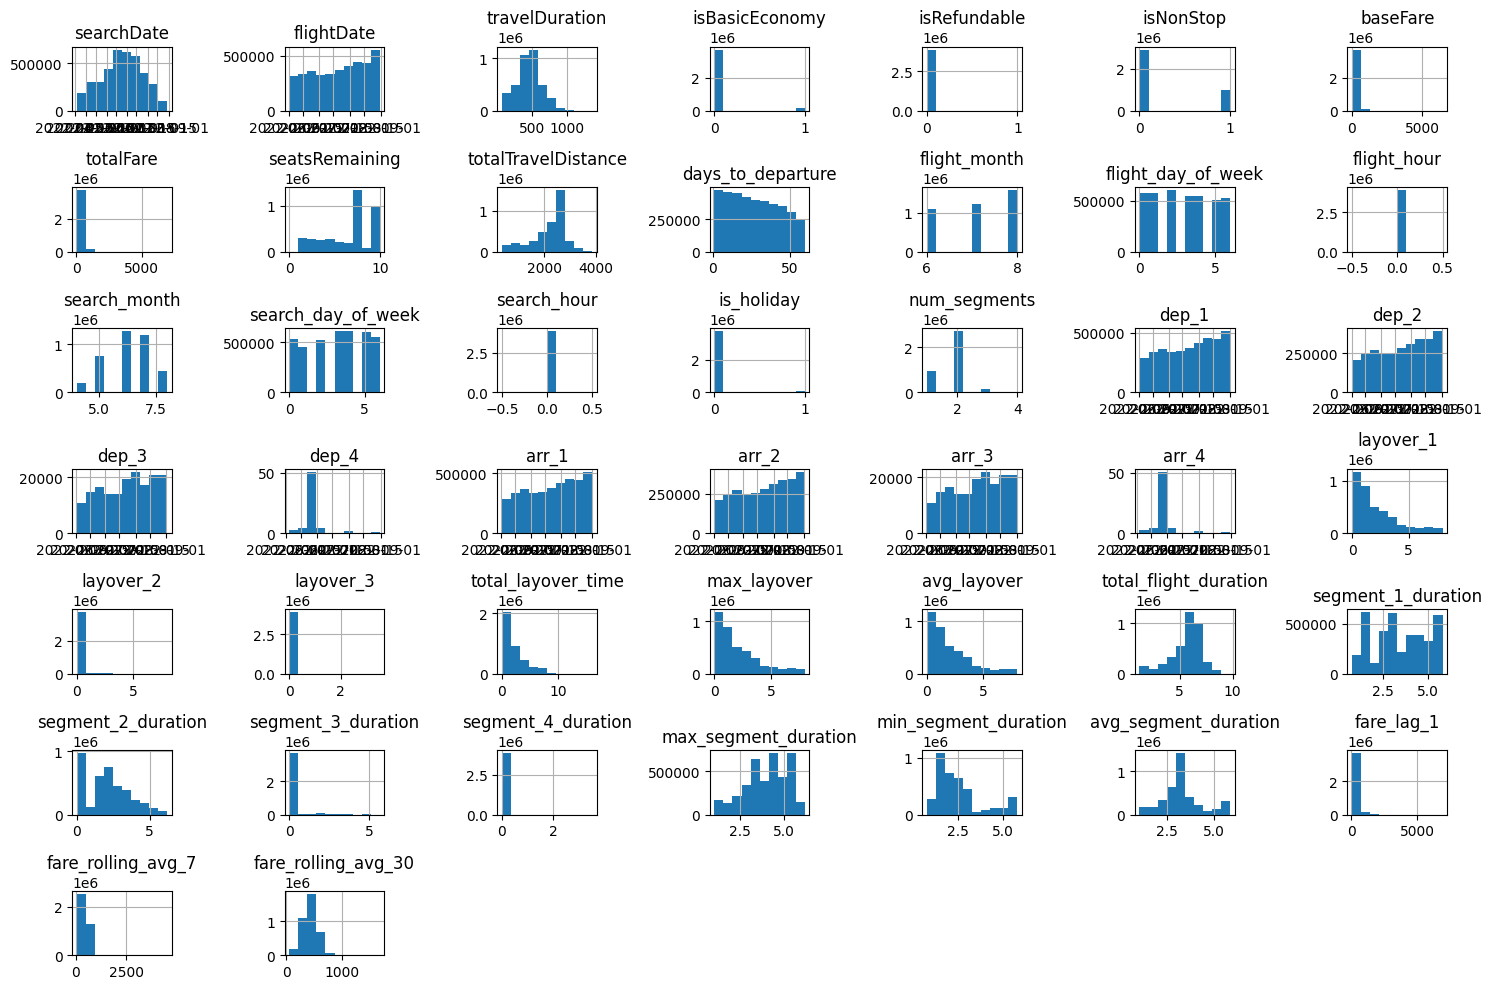

In [24]:
# Plot histograms for numerical columns
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

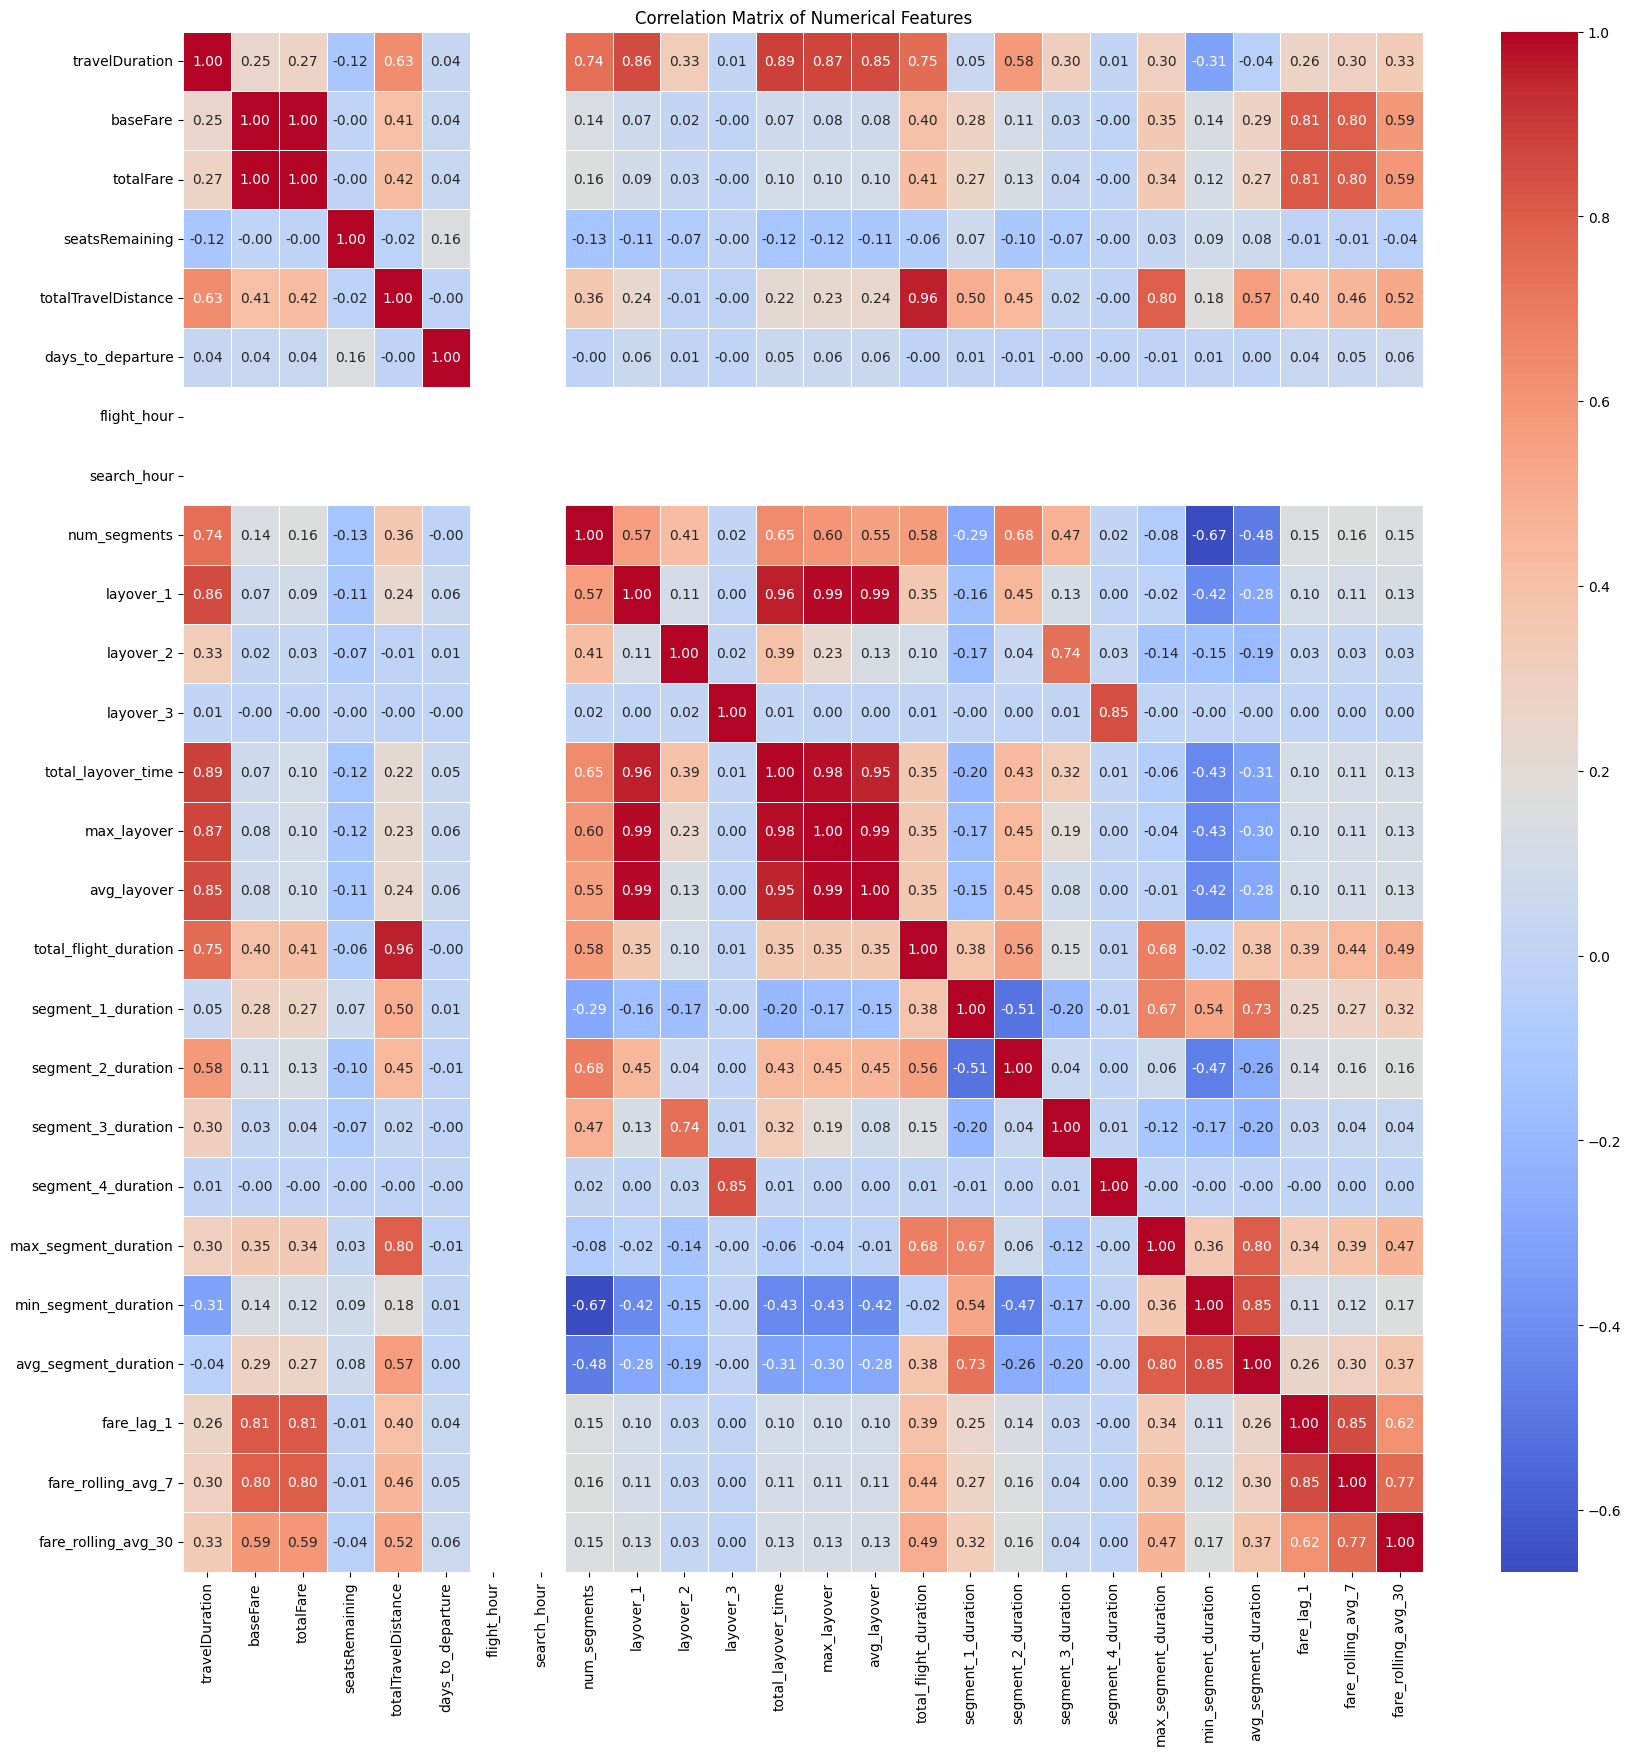

In [30]:
# List of columns to exclude (boolean or categorical columns)
exclude_columns = [
    'isBasicEconomy', 'isRefundable', 'isNonStop', 'flight_month', 
    'flight_day_of_week', 'search_month', 'search_day_of_week', 'is_holiday'
]

# Select numerical columns and drop the excluded ones
numerical_cols = df.select_dtypes(include=['float64', 'int32', 'int64']).drop(columns=exclude_columns)

# Calculate the correlation matrix
corr_matrix = numerical_cols.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


## Notes on the matrix 
Features that are actually categorical are isBasicEconomy, isRefundable, isNonStop, flight_month, flight_day_of_week, search_month, search_day_of_week, is_holiday

In [ ]:
#Drop columns that were used for statistical gathering and have been shown to have no correlation and little potential use for predictive models 
df = df.drop(['max_layover', 
              'min_segment_duration', 'avg_segment_duration'], axis=1).reset_index(drop=True)

#Drop Segment columns that have already been split or were ultimately unneeded   
df = df.drop([
    'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsDurationInSeconds', 
    'segmentsDistance'], axis=1).reset_index(drop=True)

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873359 entries, 0 to 3873358
Data columns (total 56 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   searchDate                         datetime64[ns]
 1   flightDate                         datetime64[ns]
 2   destinationAirport                 object        
 3   fareBasisCode                      object        
 4   travelDuration                     object        
 5   isBasicEconomy                     int64         
 6   isRefundable                       int64         
 7   isNonStop                          int64         
 8   baseFare                           float64       
 9   totalFare                          float64       
 10  seatsRemaining                     int64         
 11  totalTravelDistance                float64       
 12  segmentsDepartureTimeEpochSeconds  object        
 13  segmentsArrivalTimeEpochSeconds    object        
 14  se

## Handling Outliers 

In [ ]:
from scipy.stats import zscore

# Calculate Z-scores for numeric columns
numeric_cols = df.select_dtypes(include='number').columns
z_scores = df[numeric_cols].apply(zscore)

# Identify outliers where the absolute Z-score is greater than a threshold (e.g., 3)
threshold = 3
outliers = (z_scores.abs() > threshold)

# Check rows with outliers
outlier_rows = df[outliers.any(axis=1)]
